# Advanced Data Analysis - week 10

In the advanced data analysis course, we assume basic knowledge of Python, as could be acquired by attending the *Introduction to Programming* bridging course.

This notebook includes the examples presented in **Week 10** lecture and a set of exercises related with clustering using Spark Mlib.

Documentation for Spark Mlib avaialble here: [https://spark.apache.org/mllib/](https://spark.apache.org/mllib/)


### For running in Colab

In [ ]:
# Install needed software
# Run this cell once before running the other cells in the notebook

!apt-get install openjdk-11-jdk-headless
!pip install pyspark    
    

In [ ]:
# Download data
!pip install gdown
!gdown --id 19qIunlnVgqtQiqw44LLoLg33K9mgkBHE
!unzip clustering-data.zip


## Initialization

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *


spark = SparkSession.builder \
    .master("local") \
    .appName("Week 10") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "false") \
    .getOrCreate()

plt.style.use('seaborn')



## Example: cluster-data.txt

Load file cluster-data.txt.


### Load and print

Loads data and displays the data.


<AxesSubplot:xlabel='x', ylabel='y'>

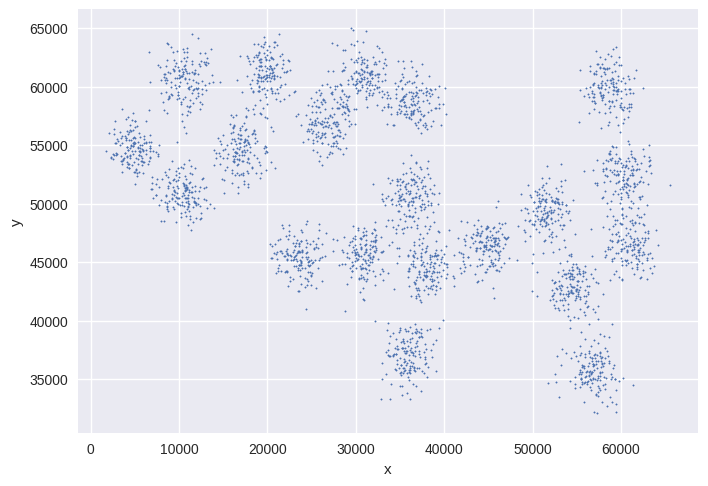

In [9]:
fileName = os.path.join( os.path.join( "data", "clustering"), "cluster-data.txt")

dataset = spark.read.option("header", True).option("inferSchema",True).csv(fileName)

datasetPD = dataset.toPandas()

datasetPD.plot.scatter(x="x",y="y",s=1)


K-means algorithm in Spark MLib assumes that the dataframe include a column **features** that contains an array with the values of the properties. This can be done as follows:

In [10]:
# Auxiliary class used to create a column composed by the values of other columns
assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
datasetKM = assembler.transform(dataset)

# Let's show 10 lines of the dataframe
datasetKM.show(10)

+-----+-----+-----------------+
|    x|    y|         features|
+-----+-----+-----------------+
|54620|43523|[54620.0,43523.0]|
|52694|42750|[52694.0,42750.0]|
|53253|43024|[53253.0,43024.0]|
|54925|42624|[54925.0,42624.0]|
|54973|43980|[54973.0,43980.0]|
|52967|42955|[52967.0,42955.0]|
|55143|40238|[55143.0,40238.0]|
|53071|44896|[53071.0,44896.0]|
|55710|44219|[55710.0,44219.0]|
|54459|43964|[54459.0,43964.0]|
+-----+-----+-----------------+
only showing top 10 rows



### K-means cluster

Loads data, train K-means and display the centroids.


In [11]:
fileName = os.path.join( os.path.join( "data", "clustering"), "cluster-data.txt")

dataset = spark.read.option("header", True).option("inferSchema",True).csv(fileName)

# Create the features column
assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
dataset = assembler.transform(dataset)

# Initialize the algorithm for 20 cluster
# setSeed to a constant allows to repeat the computation and generate exactly the same clusters
kmeans = KMeans().setK(20).setSeed(1)

# Generate a model from the dataset
model = kmeans.fit(dataset)

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
    

Cluster Centers: 
[33419.74137931 45128.31034483]
[56813.5704698 35697.3557047]
[60959.31543624 46441.02684564]
[ 4804.08108108 54722.59459459]
[23731.46153846 45470.68589744]
[58641.16 59852.84]
[36419.55033557 58760.54362416]
[10595.53333333 60619.72      ]
[26783.64779874 56977.78616352]
[30783.0915493  61002.50704225]
[51573.67320261 49327.29411765]
[54461.22972973 42821.51351351]
[60331.40397351 52416.39735099]
[19935.0979021  61333.14685315]
[16564.31818182 53626.125     ]
[17878.75362319 56062.1884058 ]
[36339.8    50412.4625]
[10325.34210526 50846.02631579]
[35982.46753247 37197.77922078]
[43563.22222222 45921.6010101 ]


With the K-means model, we can now assign each point to a cluster.

+-----+-----+-----------------+----------+
|    x|    y|         features|prediction|
+-----+-----+-----------------+----------+
|54620|43523|[54620.0,43523.0]|        11|
|52694|42750|[52694.0,42750.0]|        11|
|53253|43024|[53253.0,43024.0]|        11|
|54925|42624|[54925.0,42624.0]|        11|
|54973|43980|[54973.0,43980.0]|        11|
|52967|42955|[52967.0,42955.0]|        11|
|55143|40238|[55143.0,40238.0]|        11|
|53071|44896|[53071.0,44896.0]|        11|
|55710|44219|[55710.0,44219.0]|        11|
|54459|43964|[54459.0,43964.0]|        11|
+-----+-----+-----------------+----------+
only showing top 10 rows



<AxesSubplot:xlabel='x', ylabel='y'>

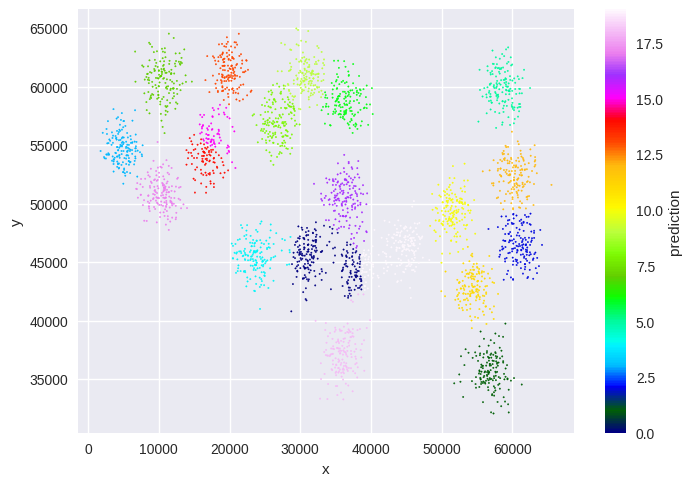

In [12]:

# Assign each element of the data set to a cluster number
predictions = model.transform(dataset)

# Let's print 10 elements
predictions.show(10)

predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x="x",y="y",c="prediction",s=1,cmap='gist_ncar')


We can compute the quality of the clustering using the Silhouette as follows. 

In [13]:
# Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(predictions)

print( "Quality of predictions (higher is better):" + str(score))


Quality of predictions (higher is better):0.7341229114232304


### Finding out the number of cluster

For finding out the "best" number of clusters, compute K-means for the value of K from 2 to 40, and plot the Silhouette value. The maximum value is the clustering with best quality.

<AxesSubplot:xlabel='num'>

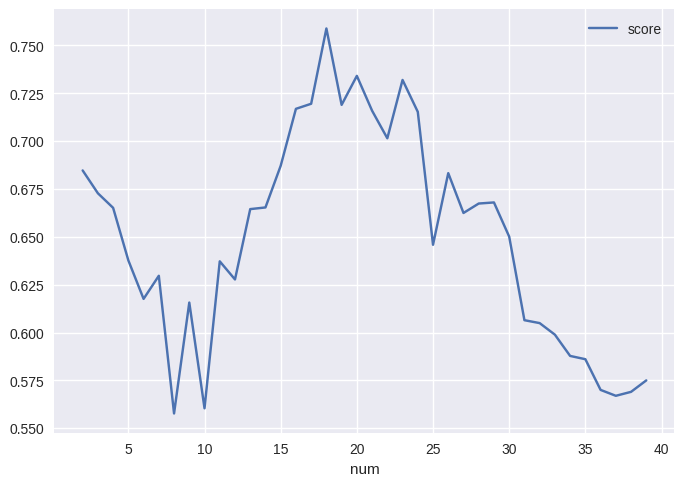

In [23]:
# Function to perform clustering of dataset data with K clusters, 
# returning the Silhouette score
def evaluate( dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score


fileName = os.path.join( os.path.join( "data", "clustering"), "cluster-data.txt")

dataset = spark.read.option("header", True).option("inferSchema",True).csv(fileName)

# Create the features column
assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
dataset = assembler.transform(dataset)


# For each value from 2 to 40 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(2,40):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(dataset,i)}).to_frame().T], ignore_index=True)

# Plot the scores    
df.plot( x="num", y="score")



Let's print the clustering that leads to a better result.

<AxesSubplot:xlabel='x', ylabel='y'>

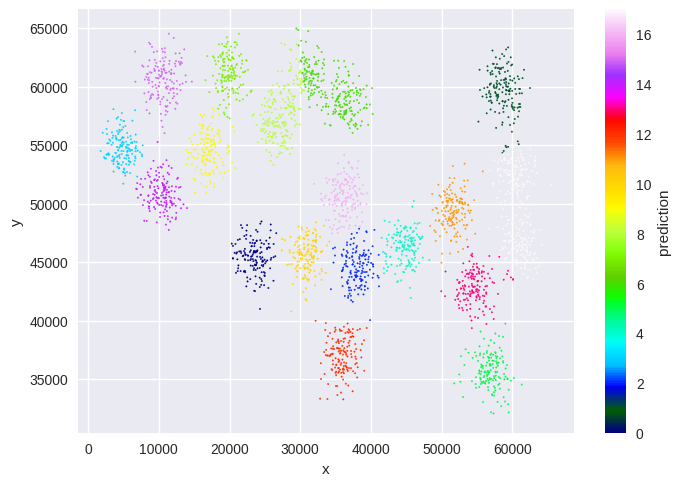

In [24]:
k = int(df.nlargest(1,"score")["num"].values[0])

kmeans = KMeans().setK(k).setSeed(1)
model = kmeans.fit(dataset)
predictions = model.transform(dataset)

predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x="x",y="y",c="prediction",s=1,cmap='gist_ncar')


### K-means cluster and SQL

Consider you want to consider only the clusters for which the value of x is smaller than 40000. 

You can manipulate the input sets using the DataFrames API of the SQL API.

Cluster Centers: 
[30808.77241379 45571.11724138]
[30783.0915493  61002.50704225]
[ 4804.08108108 54722.59459459]
[19903.18       61170.26666667]
[26783.64779874 56977.78616352]
[23495.15540541 45438.83783784]
[35903.59731544 37050.80536913]
[10595.53333333 60619.72      ]
[17043.57333333 54549.93333333]
[36368.27210884 58760.46258503]
[37983.97272727 44040.42727273]
[10325.34210526 50846.02631579]
[36186.15447154 51102.34146341]
[36351.7 47446.2]
Quality of predictions (higher is better):0.7620776759529572


<AxesSubplot:xlabel='x', ylabel='y'>

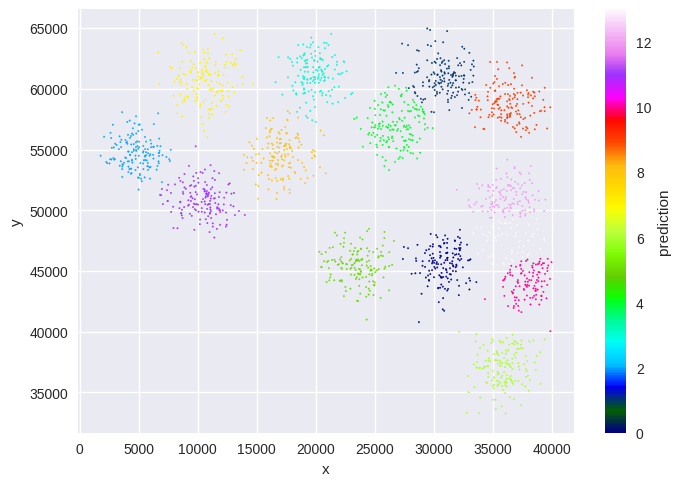

In [25]:
fileName = os.path.join( os.path.join( "data", "clustering"), "cluster-data.txt")

dataset = spark.read.option("header", True).option("inferSchema",True).csv(fileName)

dataset.createOrReplaceTempView("data")
dataset = spark.sql( "SELECT x, y FROM data WHERE x < 40000")

assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
dataset = assembler.transform(dataset)

# Training KMeans
kmeans = KMeans().setK(14).setSeed(1)
model = kmeans.fit(dataset)

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# Make predictions
predictions = model.transform(dataset)

# Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
evaluator.setPredictionCol("prediction")

print( "Quality of predictions (higher is better):" + str(evaluator.evaluate(predictions)))


predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x="x",y="y",c="prediction",s=1,cmap='gist_ncar')



## Exercise

For data points for which the vlue of y is larger than 40000, find out the appropriate number of clusters and present the resulting cluster.